# Semantic Segmentation with U-Net
- Dataset: MNIST Extended
- Reference: https://github.com/LukeTonin/simple-deep-learning 

### Imports

In [1]:
import torch
import torch.nn as nn
import torchvision

In [2]:
# device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {DEVICE}")

device: cuda


In [3]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels) 
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [4]:
# Check the block
encoder_block = Block(1, 64)
x = torch.rand(1, 1, 60, 60)
print(f'Shape of the encoder block: {encoder_block(x).shape}')

Shape of the encoder block: torch.Size([1, 64, 60, 60])


In [5]:
class Encoder(nn.Module):
    def __init__(self, channels=(1, 64, 128, 256, 512)):
        super().__init__()
        self.encoder_blocks = nn.ModuleList(
            [Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)]
        )
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        block_outputs = []
        for block in self.encoder_blocks:
            x = block(x)
            block_outputs.append(x)
            x = self.pool(x)
        return block_outputs

In [6]:
# Check the encoder
encoder = Encoder()
x = torch.rand(1, 1, 60, 60)
encoder_outputs = encoder(x)

for op in encoder_outputs:
    print(f'Shape of the encoder output: {op.shape}')

Shape of the encoder output: torch.Size([1, 64, 60, 60])
Shape of the encoder output: torch.Size([1, 128, 30, 30])
Shape of the encoder output: torch.Size([1, 256, 15, 15])
Shape of the encoder output: torch.Size([1, 512, 7, 7])


In [7]:
class Decoder(nn.Module):
    def __init__(self, channels=(512, 256, 128, 64)):
        super().__init__()
        self.channels = channels
        self.decoder_blocks = nn.ModuleList(
            [Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)]
        )
        self.upconvolution = nn.ModuleList(
            [nn.ConvTranspose2d(channels[i], channels[i + 1], kernel_size=2, stride=2) for i in range(len(channels) - 1)]
        )

    def forward(self, x, encoder_outputs):
        for i in range(len(self.channels) - 1):
            x = self.upconvolution[i](x)
            encoder_output = self.crop(encoder_outputs[i], x)
            x = torch.cat([x, encoder_output], dim=1)
            x = self.decoder_blocks[i](x)
        return x

    # Following the paper, we crop the encoder output to match the shape of decoder output    
    def crop(self, encoder_output, tensor):
        _, _, H, W = tensor.shape
        encoder_output = torchvision.transforms.CenterCrop([H, W])(encoder_output)
        return encoder_output

In [8]:
# Check the decoder
decoder = Decoder()
x = torch.rand(1, 512, 7, 7)
decoder(x, encoder_outputs[::-1][1:]) # Pass the encoder outputs in reverse order
print(f'Shape of the decoder output: {decoder(x, encoder_outputs[::-1][1:]).shape}')

Shape of the decoder output: torch.Size([1, 64, 56, 56])


### UNet model

<p align="center">
  <img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width=45% />
</p>

Reference: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net

In [9]:
class UNet(nn.Module):
    def __init__(self, encoder_channels=(1, 64, 128, 256, 512), decoder_channels=(512, 256, 128, 64), num_classes=5, retain_dim=False, output_size=(60, 60)):
        super().__init__()
        self.encoder = Encoder(encoder_channels)
        self.decoder = Decoder(decoder_channels)
        self.head = nn.Conv2d(decoder_channels[-1], num_classes, kernel_size=1)
        self.retain_dim = retain_dim
        self.output_size = output_size

    def forward(self, x):
        encoder_outputs = self.encoder(x)
        out = self.decoder(encoder_outputs[-1], encoder_outputs[::-1][1:])
        out = self.head(out)
        if self.retain_dim:
            out = nn.functional.interpolate(out, self.output_size)
        return out

In [10]:
# Check the model
model = UNet(retain_dim=True)
x = torch.rand(1, 1, 60, 60)
out = model(x)
print(f'Shape of the model output: {out.shape}')

Shape of the model output: torch.Size([1, 5, 60, 60])


### Import libraries

In [11]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from torchinfo import summary
import cv2
from typing import List, Tuple
from PIL import Image
import imutils
from pathlib import Path
import pprint

import torchmetrics
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

import config
import dataset_generation
import utils

import importlib
importlib.reload(dataset_generation)

2024-04-15 10:47:35.409177: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 10:47:35.433794: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 10:47:36.029332: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<module 'dataset_generation' from '/home/kpatel2s/work/bmw/unet_task_3/sdp/unet_segmentation/dataset_generation.py'>

### Load hyperparameters

In [12]:
NUM_WORKERS = config.NUM_WORKERS
BATCH_SIZE = config.BATCH_SIZE
PIN_MEMORY = config.PIN_MEMORY

TOTAL_SAMPLES = config.TOTAL_SAMPLES
num_classes = config.NUM_CLASSES

EPOCHS = config.EPOCHS
LR_RATE = config.LR_RATE

TRAIN_VAL_SPLIT = config.TRAIN_VAL_SPLIT

### Create data loaders

In [13]:
class MNISTExtendedDataset(Dataset):
  def __init__(self, count, transform=None):
    
    self.input_images, self.target_masks, _, _ = dataset_generation.mnist_extended_dataset(total_train_samples=count, total_test_samples=1, num_classes=num_classes)

    # permute target mask 
    self.target_masks = np.transpose(self.target_masks, (0, 3, 1, 2))

    # Convert to datatype float32
    self.input_images = self.input_images.astype(np.float32)
    self.target_masks = self.target_masks.astype(np.float32)

    self.transform = transform

  def __len__(self):
    return len(self.input_images)

  def __getitem__(self, idx):
    image = self.input_images[idx]
    mask = self.target_masks[idx]
    if self.transform:
      image = self.transform(image)

    return [image, mask]

In [14]:
from torch.utils.data import random_split

trans = transforms.Compose([
  transforms.ToTensor()
])

train_size = int(TRAIN_VAL_SPLIT * TOTAL_SAMPLES)
val_size = int((1 - TRAIN_VAL_SPLIT) * TOTAL_SAMPLES)

train_data = MNISTExtendedDataset(count=train_size, transform=trans)
val_data = MNISTExtendedDataset(count=val_size, transform=trans)
test_data = MNISTExtendedDataset(count=val_size, transform=trans)

print(f'Shape of train_data: {len(train_data)}')
print(f'Shape of val_data: {len(val_data)}')
print(f'Shape of test_data: {len(test_data)}')

Shape of train_data: 700
Shape of val_data: 300
Shape of test_data: 300


In [15]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=NUM_WORKERS, 
                          pin_memory=PIN_MEMORY)

val_loader = DataLoader(dataset=val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY)

test_loader = DataLoader(dataset=test_data, 
                         batch_size=1, 
                         shuffle=False, 
                         num_workers=NUM_WORKERS, 
                         pin_memory=PIN_MEMORY)

print(f'Number of train batches: {len(train_loader)}')
print(f'Number of val batches: {len(val_loader)}')
print(f'Number of test batches: {len(test_loader)}')

Number of train batches: 22
Number of val batches: 10
Number of test batches: 300


In [17]:
# Get a train input and output pair
i = np.random.randint(0, len(train_loader.dataset))
train_x_sample, train_y_sample = next(iter(train_loader))
print(f'Shape of train_x_sample: {train_x_sample.shape}')
print(f'Shape of train_y_sample: {train_y_sample.shape}')

# get min and max of train y
train_y_min, train_y_max = train_y_sample.min(), train_y_sample.max()
print(f'Min and max of train_y_sample: {train_y_min}, {train_y_max}')

Shape of train_x_sample: torch.Size([32, 1, 60, 60])
Shape of train_y_sample: torch.Size([32, 5, 60, 60])
Min and max of train_y_sample: 0.0, 1.0


In [18]:
train_x_sample.dtype, train_y_sample.dtype

(torch.float32, torch.float32)

### Visualize the dataset

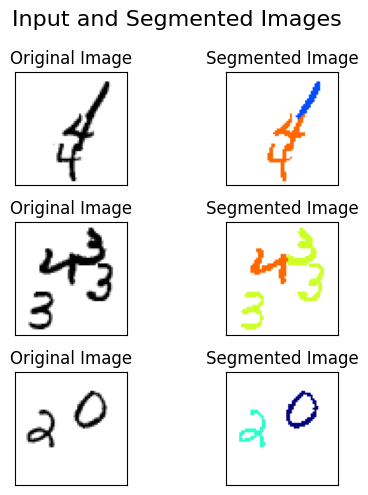

In [19]:
from matplotlib.colors import ListedColormap

random_indices = np.random.choice(len(train_loader.dataset), size=6, replace=False)

fig, axs = plt.subplots(3, 2, figsize=(5, 5))  # Adjust the figure size as needed

for i, ax in enumerate(axs.flat):
    idx = random_indices[i // 2]
    data = train_loader.dataset[idx]

    # Just to put in order in the plot
    if i % 2 == 0:
        image = data[0]
        image = image.permute(1, 2, 0)
        ax.imshow(image, cmap=plt.cm.binary)  
        ax.set_title("Original Image")
    else:
        segmentation = data[1]  
        segmentation = np.transpose(segmentation, (1, 2, 0))
        seg_img = dataset_generation.display_segmented_image(segmentation)
        ax.imshow(seg_img, cmap=plt.cm.binary)
        ax.set_title("Segmented Image")

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

fig.suptitle('Input and Segmented Images', fontsize=16)
plt.tight_layout()
plt.show()

### Load the model

In [20]:
unet_model = UNet(retain_dim=True, num_classes=num_classes, output_size=(60, 60)).to(DEVICE)

In [21]:
# Model summary
summary(model=unet_model,
        input_size=(1, 1, 60, 60),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        depth=5
        )

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
UNet (UNet)                              [1, 1, 60, 60]       [1, 5, 60, 60]       --                   True
├─Encoder (encoder)                      [1, 1, 60, 60]       [1, 64, 60, 60]      --                   True
│    └─ModuleList (encoder_blocks)       --                   --                   (recursive)          True
│    │    └─Block (0)                    [1, 1, 60, 60]       [1, 64, 60, 60]      --                   True
│    │    │    └─Conv2d (conv1)          [1, 1, 60, 60]       [1, 64, 60, 60]      640                  True
│    │    │    └─BatchNorm2d (bn)        [1, 64, 60, 60]      [1, 64, 60, 60]      128                  True
│    │    │    └─ReLU (relu)             [1, 64, 60, 60]      [1, 64, 60, 60]      --                   --
│    │    │    └─Conv2d (conv2)          [1, 64, 60, 60]      [1, 64, 60, 60]      36,928               True
│    │    │    └

### Loss function and optimizer

In [22]:
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=LR_RATE)

### Training loop

In [23]:
utils.set_seed()

from timeit import default_timer as timer
start_time = timer()

# Store train and validation losses
train_losses = []
val_losses = []

for epoch in range(EPOCHS):

    unet_model.train()

    train_loss = 0.0
    val_loss = 0.0

    for x, y in train_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        pred_logits = unet_model(x)
        loss = loss_fn(pred_logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    unet_model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            pred_logits = unet_model(x)
            loss = loss_fn(pred_logits, y)

            val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

    print(f'Epoch: {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

end_time = timer()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

Epoch: 1/20 | Train Loss: 0.4996 | Val Loss: 0.5057
Epoch: 2/20 | Train Loss: 0.2956 | Val Loss: 0.4638
Epoch: 3/20 | Train Loss: 0.1841 | Val Loss: 0.4007
Epoch: 4/20 | Train Loss: 0.1246 | Val Loss: 0.3254
Epoch: 5/20 | Train Loss: 0.0935 | Val Loss: 0.3852
Epoch: 6/20 | Train Loss: 0.0758 | Val Loss: 0.2777
Epoch: 7/20 | Train Loss: 0.0636 | Val Loss: 0.3282
Epoch: 8/20 | Train Loss: 0.0552 | Val Loss: 0.2894
Epoch: 9/20 | Train Loss: 0.0475 | Val Loss: 0.3118
Epoch: 10/20 | Train Loss: 0.0416 | Val Loss: 0.2611
Epoch: 11/20 | Train Loss: 0.0366 | Val Loss: 0.2761
Epoch: 12/20 | Train Loss: 0.0327 | Val Loss: 0.3076
Epoch: 13/20 | Train Loss: 0.0289 | Val Loss: 0.3453
Epoch: 14/20 | Train Loss: 0.0273 | Val Loss: 0.2486
Epoch: 15/20 | Train Loss: 0.0253 | Val Loss: 0.2700
Epoch: 16/20 | Train Loss: 0.0228 | Val Loss: 0.2881
Epoch: 17/20 | Train Loss: 0.0209 | Val Loss: 0.2772
Epoch: 18/20 | Train Loss: 0.0198 | Val Loss: 0.2422
Epoch: 19/20 | Train Loss: 0.0196 | Val Loss: 0.2462
Ep

### Plot losses

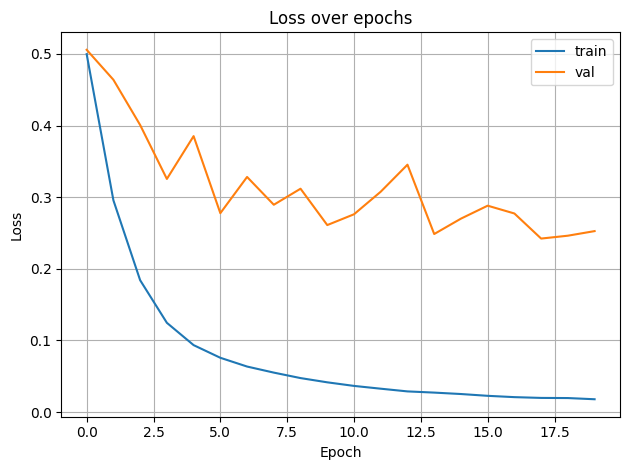

In [24]:
# Plot train and validation loss over epochs
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()
plt.show()

### Calculate mean IoU

In [ ]:
import torchmetrics

iou_metric = torchmetrics.JaccardIndex(task='multiclass', num_classes=num_classes).to(DEVICE)

# Calculate mean IoU

unet_model.eval()
with torch.no_grad():
    total_iou = 0.0
    for x, y in test_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        pred_logits = unet_model(x)
        pred_logits = torch.softmax(pred_logits, dim=1)
        pred_masks = torch.argmax(pred_logits, dim=1)
        y_gt = torch.argmax(y, dim=1)

        iou = iou_metric(pred_masks, y_gt)
        total_iou += iou.item()

    mean_iou = total_iou / len(test_loader)
    print(f'Mean IoU: {mean_iou:.4f}')


In [30]:

def visualize_predictions(orig_img, gt_img, pred_img):
    plt.clf()
    plt.figure(figsize=(18, 6))  

    # Plot the original image
    ax1 = plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
    image = orig_img.permute(1, 2, 0).numpy()  
    ax1.imshow(image, cmap=plt.cm.binary)
    ax1.set_title("Original Image")
    ax1.axis('off')  

    # Plot the ground truth image
    ax2 = plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
    gt_segmentation = gt_img.permute(1, 2, 0).numpy() 
    gt_seg_img = dataset_generation.display_segmented_image(gt_segmentation)  
    ax2.imshow(gt_seg_img)
    ax2.set_title("Ground Truth Image")
    ax2.axis('off')  # Hide the axis

    # Plot the predicted image
    ax3 = plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
    pred_segmentation = pred_img.permute(1, 2, 0).numpy()
    pred_seg_img = dataset_generation.display_segmented_image(pred_segmentation, threshold=0.5)
    ax3.imshow(pred_seg_img)
    ax3.set_title("Predicted Image")
    ax3.axis('off')  # Hide the axis

    plt.show()

### Visualize predictions

In [31]:
def min_max_normalize(x, xmin, xmax):
    return (x - xmin) / (xmax - xmin)

Min and max of y: 0.0, 1.0
Min and max of pred: -3.7996301651000977, -0.029768049716949463
Min and max of pred: 0.0, 1.0
Pred argmax shape: torch.Size([32, 1, 60, 60])


<Figure size 640x480 with 0 Axes>

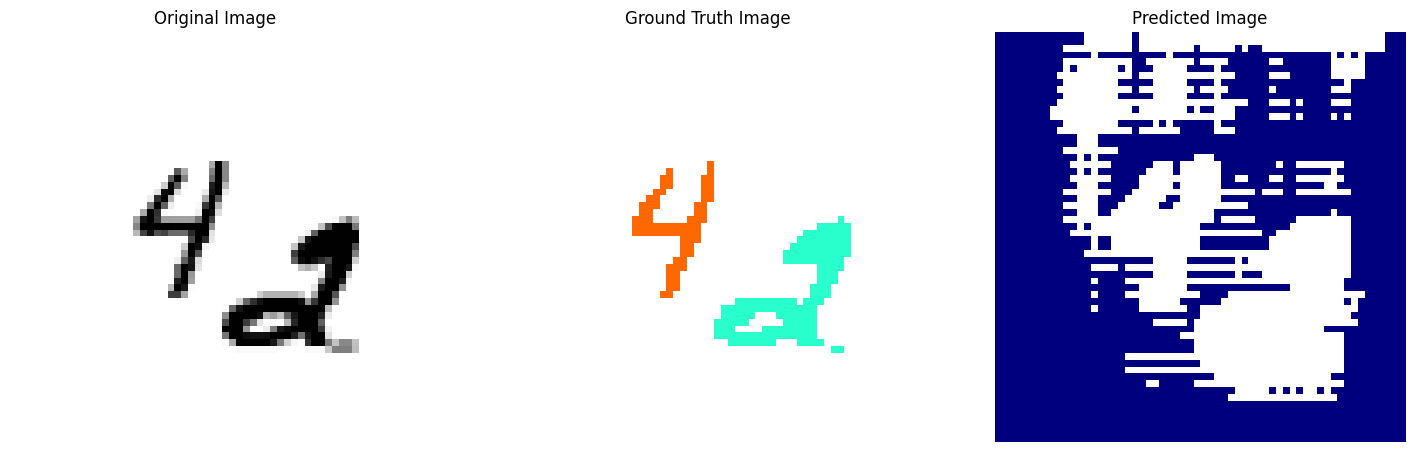

In [33]:


unet_model.eval()
with torch.no_grad():

    for idx, (x, y) in enumerate(train_loader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        pred_logits = unet_model(x)

        # pred_norm = min_max_normalize(pred_logits, pred_logits.min(), pred_logits.max())

        # Min and max of train y
        print(f'Min and max of y: {y.min()}, {y.max()}')
        print(f'Min and max of pred: {pred_logits.min()}, {pred_logits.max()}')
        print(f'Min and max of pred: {pred_norm.min()}, {pred_norm.max()}')

        pred_softmax = torch.softmax(pred_logits, dim=1)
        pred_argmax = torch.argmax(pred_softmax, dim=1).unsqueeze(1)

        print(f'Pred argmax shape: {pred_argmax.shape}')

        visualize_predictions(x[0].cpu(), y[0].cpu(), pred_argmax[0].cpu())
        break
        
        